<a href="https://colab.research.google.com/github/sourcecode369/100-days-of-ml-code/blob/master/Severstal_Steel_Defect_Detection/Severstal_Steel_Defect_Detection_2_Step_Pipeline_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving model.png to model.png
Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rhtsingh","key":"05e5c425aae6dfba32a031192446751a"}',
 'model.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02o\x00\x00?Y\x08\x06\x00\x00\x006\xa1\x16\xaa\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddy|T\xf5\xbd\xff\xf1\xf7$\x99\xccd\x9d\xb0I\x90$\x04\x02\n("\n\x8a\xb1x\xc1\xf6\xaaH\xa5,\t\xa0(\x17Z\xae\x88\xd7\x06\x14\x05\x7f\x8a\xd4"\xaeXB\xcbb\xddJ[PH\x02\\qa\xf1\xaaW\xd1\x8a\xa0\xb5\n\x82,\xa2\xc8bi\xd8\x92\x00\x01\xb3}~\x7f\xf4\xc1\xdc\x8e\t\x90e\xc8p\x86\xd7\xf3\xf1\x98?\xf2=\xdfs\xbe\x9f\xf3=\t\xf3\xe6\x9c3g\\ff\x02\x00\x00\x80\x13\x14D\x84\xba\x02\x00\x00\x00\xd4\x1e\xe1\r\x00\x00\xc0A\x08o\x00\x00\x00\x0eBx\x03\x00\x00p\x90\xa8P\x17\x00\x9c\xabf\xcc\x98\xa15k\xd6\x84\xba\x0c\xa0\xc1\n\n\nB]\x02pN\xe1\xcc\x1b\x10"k\xd6\xac\xd1G\x1f}\x14\xea2\x80z\xdb\xbd{\xb7\x16/^\x1c\xea2\x80s\x0eg\xde\x80\x10\xea\xd9\xb3\'g-\xe0X\xf9\xf9\xf9\x1a:th\xa8\xcb\x00\xce9\x9cy\x03\x00\x00p\x10\xc2\x1b\x00\x00\x80\x83\

In [2]:
from google.colab import files
files.upload()

Saving resnet_model.h5 to resnet_model.h5


In [0]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c severstal-steel-defect-detection

  0% 0.00/6.91M [00:00<?, ?B/s]
100% 6.91M/6.91M [00:00<00:00, 63.5MB/s]
  0% 0.00/141k [00:00<?, ?B/s]
100% 141k/141k [00:00<00:00, 141MB/s]
100% 1.16G/1.16G [00:07<00:00, 196MB/s]
100% 1.16G/1.16G [00:07<00:00, 171MB/s]
 89% 115M/129M [00:00<00:00, 136MB/s] 
100% 129M/129M [00:00<00:00, 166MB/s]


In [5]:
import zipfile
import os
import shutil
zip_files = []
for file_name in os.listdir():
  print(f"{file_name}   {zipfile.is_zipfile(file_name)}") 
  if zipfile.is_zipfile(file_name):
    zip_files.append(file_name)

.config   False
model.png   False
test_images.zip   True
train_images.zip   True
sample_submission.csv   False
train.csv.zip   True
resnet_model.h5   False
sample_data   False


In [0]:
for file in zip_files:
  if ".csv" in file:
    with zipfile.ZipFile(file, 'r') as zip_ref:
      zip_ref.extractall()
  else:
    with zipfile.ZipFile(file, 'r') as zip_ref:
      dir = file.replace(".zip","")
      zip_ref.extractall(dir)

In [0]:
!rm -rf test_images.zip
!rm -rf train_images.zip
!rm -rf train.csv.zip

In [8]:
import os
os.environ["PYTHONHASHSEED"] = str(101)
import gc
gc.enable()
gc.collect()

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

import keras
from keras import backend as K
from keras.models import Model 
from keras.layers import Input 
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D 
from keras.layers.merge import concatenate 
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint 
from keras.optimizers import Adam, Nadam
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm 
from sklearn.model_selection import train_test_split 

Using TensorFlow backend.


In [9]:
train_df = pd.read_csv('train.csv')
print(train_df.shape)
train_df.head()

(50272, 2)


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [10]:
submission_df = pd.read_csv('sample_submission.csv')
print(submission_df.shape)
submission_df.head()

(7204, 2)


,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,1 1
1,004f40c73.jpg_2,1 1
2,004f40c73.jpg_3,1 1
3,004f40c73.jpg_4,1 1
4,006f39c41.jpg_1,1 1


In [0]:
unique_test_images = submission_df.ImageId_ClassId.apply(lambda x: x.split("_")[0]).unique()

In [12]:
print(f"unique test images: {unique_test_images}")
print(f"unique test images shape: {unique_test_images.shape}")

unique test images: ['004f40c73.jpg' '006f39c41.jpg' '00b7fb703.jpg' ... 'ffbf79783.jpg'
 'ffc9a6187.jpg' 'ffdb60677.jpg']
unique test images shape: (1801,)


In [13]:
train_df["isNan"] = pd.isna(train_df.EncodedPixels).astype(np.int)

train_df["ImageId"] = train_df.ImageId_ClassId.apply(
    lambda x: x.split('_')[0]
)
train_df.head()

,ImageId_ClassId,EncodedPixels,isNan,ImageId
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0,0002cc93b.jpg
1,0002cc93b.jpg_2,NaN,1,0002cc93b.jpg
2,0002cc93b.jpg_3,NaN,1,0002cc93b.jpg
3,0002cc93b.jpg_4,NaN,1,0002cc93b.jpg
4,00031f466.jpg_1,NaN,1,00031f466.jpg


In [14]:
train_nan_df = train_df.groupby("ImageId",axis=0).agg("sum") 
train_nan_df.reset_index(inplace=True)
train_nan_df.rename(columns={"isNan":"missingCount"}, inplace=True)
train_nan_df["allMissing"] = (train_nan_df["missingCount"]==4).astype(np.int)
train_nan_df.head()

,ImageId,missingCount,allMissing
0,0002cc93b.jpg,3,0
1,00031f466.jpg,4,1
2,000418bfc.jpg,4,1
3,000789191.jpg,4,1
4,0007a71bf.jpg,3,0


In [15]:
test_nan_df = pd.DataFrame(unique_test_images, columns=['ImageId'])
print(test_nan_df.shape)
test_nan_df.head()

(1801, 1)


,ImageId
0,004f40c73.jpg
1,006f39c41.jpg
2,00b7fb703.jpg
3,00bbcd9af.jpg
4,0108ce457.jpg


In [16]:
print(train_nan_df.shape)
train_nan_df.head()

(12568, 3)


,ImageId,missingCount,allMissing
0,0002cc93b.jpg,3,0
1,00031f466.jpg,4,1
2,000418bfc.jpg,4,1
3,000789191.jpg,4,1
4,0007a71bf.jpg,3,0


In [17]:
print(train_df.shape)
train_df.head()

(50272, 4)


,ImageId_ClassId,EncodedPixels,isNan,ImageId
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0,0002cc93b.jpg
1,0002cc93b.jpg_2,NaN,1,0002cc93b.jpg
2,0002cc93b.jpg_3,NaN,1,0002cc93b.jpg
3,0002cc93b.jpg_4,NaN,1,0002cc93b.jpg
4,00031f466.jpg_1,NaN,1,00031f466.jpg


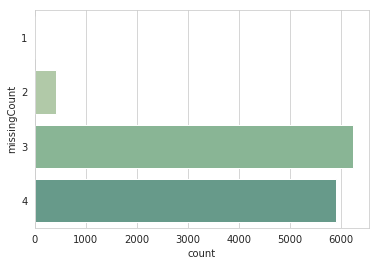

In [18]:
import seaborn as sns
sns.set_style("whitegrid")
sns.countplot(y="missingCount",data=train_nan_df, palette=sns.cubehelix_palette(8, start=.5, rot=-.75))

In [0]:
def load_image(code, base, resize=True):
  path = f'{base}/{code}'
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (256,256))
  return img

def validate_path(path):
  if not os.path.exists(path):
    os.makedirs(path)

In [20]:
import os
os.getcwd()

'/content'

In [21]:
train_path = "../train"
validate_path(train_path)

for code in tqdm(train_nan_df.ImageId):
  img = load_image(
      code, "/content/train_images", 
  )
  path = code.replace(".jpg","")
  cv2.imwrite(f"{train_path}/{path}.png",img)

100%|██████████| 12568/12568 [01:59<00:00, 105.29it/s]


In [0]:
train_nan_df["ImageId"] = train_nan_df.ImageId.apply(lambda x: x.replace(".jpg",".png"))

In [23]:
test_path = '../test'
validate_path(test_path)

def load_test_images(code, base, resize=True):
  path = f"{base}/{code}"
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (256, 256))
  return img

for code in tqdm(test_nan_df.ImageId):
  img = load_test_images(code, "/content/test_images", resize=True)
  path = code.replace(".jpg", "")
  cv2.imwrite(f"{test_path}/{path}.png",img) 

100%|██████████| 1801/1801 [00:15<00:00, 116.75it/s]


In [0]:
test_nan_df["ImageId"] = test_nan_df.ImageId.apply(lambda x: x.replace(".jpg",".png"))

In [0]:
BATCH_SIZE = 32
def create_datagen():
  return ImageDataGenerator(
      zoom_range=0.1,
      fill_mode="constant",
      cval=0,
      rotation_range=10,
      height_shift_range = 0.1,
      width_shift_range= 0.1,
      horizontal_flip = True,
      vertical_flip = True, 
      rescale = 1/255.,
      validation_split = 0.15
  )

def create_test_gen():
  return ImageDataGenerator(rescale=1/255.).flow_from_dataframe(test_nan_df,
                                                                directory="../test/",
                                                                x_col="ImageId",
                                                                target_size=(256,256),
                                                                class_mode=None,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False
                                                                )
def create_flow(datagen, subset):
  return datagen.flow_from_dataframe(
      train_nan_df,
      directory = "../train/",
      x_col="ImageId",
      y_col="allMissing",
      class_mode="other",
      target_size=(256,256),
      BATCH_SIZE=BATCH_SIZE,
      subset=subset
  )      

In [26]:
data_generator = create_datagen()
train_gen = create_flow(data_generator, "training")
val_generator = create_flow(data_generator, "validation")
test_gen = create_test_gen()

Found 10683 validated image filenames.
Found 1885 validated image filenames.
Found 1801 validated image filenames.


In [0]:
from keras.applications import ResNet50
from keras.layers import *
from keras.utils import plot_model
from keras import Sequential

In [0]:
def build_model():
  resnet = ResNet50(
      include_top = False,
      input_shape = (256,256,3),
      weights = "imagenet"
  )
  resnet.trainable = False
  model = Sequential()
  model.add(resnet)
  model.add(GlobalAveragePooling2D())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(512, activation="relu",kernel_initializer="he_uniform"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(1, activation="sigmoid"))

  model.compile(
      loss = "binary_crossentropy",
      optimizer = Nadam(),
      metrics = ["accuracy"]
  )

  model.summary()
  
  plot_model(model)
  
  return model

In [56]:
model = build_model()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)              

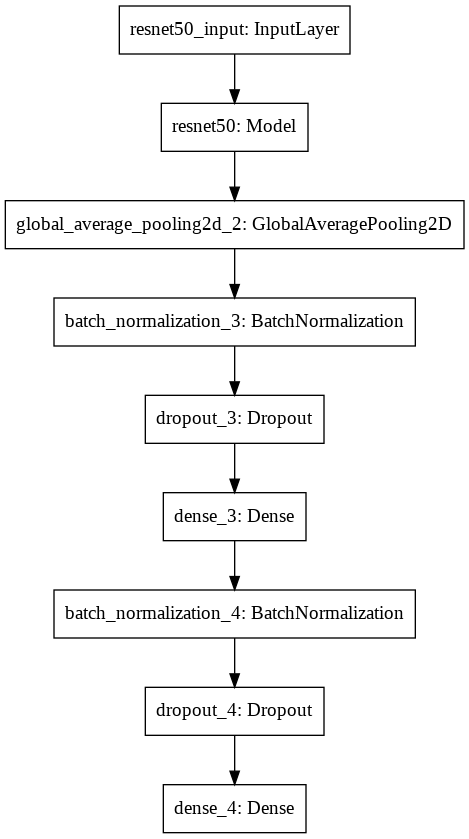

In [46]:
plot_model(model)

In [0]:
from keras.callbacks import *

In [0]:
total_steps = train_nan_df.shape[0] // BATCH_SIZE

checkpoint = ModelCheckpoint(
    "resnet_model.h5",
    monitor = "val_acc",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = "auto"
)

reduce_lr = ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.3,
    patience = 5,
    verbose = 1,
    min_lr = 1e-6
)

early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 8,
    verbose = 1,
    mode = "auto",
)

# history = model.fit_generator(
#     train_gen, 
#     steps_per_epoch = total_steps*0.85,
#     validation_data = val_generator,
#     validation_steps = total_steps*0.15,
#     epochs = 10,
#     callbacks=[early_stopping, reduce_lr, checkpoint]
# )

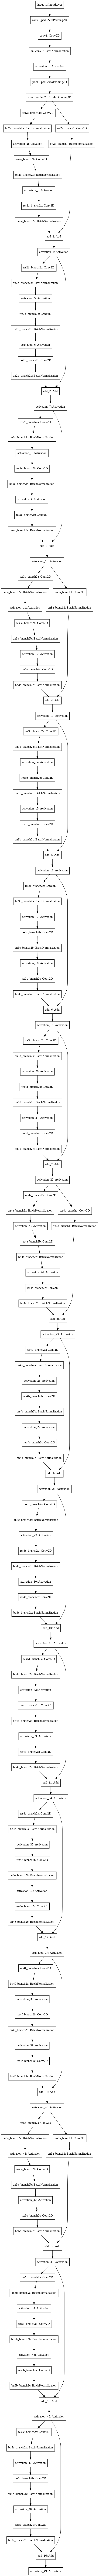

In [35]:
plot_model(model.layers[0])

In [57]:
print("Number of layers in the base model: ", len(model.layers))
print("Number of resnet layers: ", len(model.layers[0].layers))
fine_tune_at = 0
model.layers[0].trainable = True

Number of layers in the base model:  8
Number of resnet layers:  175


In [0]:
for i in range(1, 95):
  model.layers[0].layers[i].trainable=False

In [0]:
model.load_weights("resnet_model.h5", reshape=True)

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer = Nadam(),
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)              

In [63]:
fined_history = model.fit_generator(
    train_gen, 
    steps_per_epoch = total_steps*0.85,
    validation_data = val_generator,
    validation_steps = total_steps*0.15,
    epochs = 10,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/10
334/333 [==============================] - 288s 862ms/step - loss: 0.1376 - acc: 0.9470 - val_loss: 0.1567 - val_acc: 0.9416

Epoch 00001: val_acc improved from -inf to 0.94164, saving model to resnet_model.h5
Epoch 2/10
334/333 [==============================] - 264s 789ms/step - loss: 0.1476 - acc: 0.9444 - val_loss: 0.1293 - val_acc: 0.9480

Epoch 00002: val_acc improved from 0.94164 to 0.94801, saving model to resnet_model.h5
Epoch 3/10
334/333 [==============================] - 265s 794ms/step - loss: 0.1398 - acc: 0.9468 - val_loss: 0.1323 - val_acc: 0.9496

Epoch 00003: val_acc improved from 0.94801 to 0.94960, saving model to resnet_model.h5
Epoch 4/10
334/333 [==============================] - 267s 798ms/step - loss: 0.1356 - acc: 0.9488 - val_loss: 0.1412 - val_acc: 0.9427

Epoch 00004: val_acc did not improve from 0.94960
Epoch 5/10
334/333 [==============================] - 264s 792ms/step - loss: 0.1296 - acc: 0.9513 - val_loss: 0.1303 - val_acc: 0.9438

Epoch 0

In [0]:
def plot_learning(history):
    plt.figure(figsize=(20,12))
    plt.subplot(2,1,1)
    plt.plot(history["epochs"], history["acc"], label="Training Accuracy")
    plt.plot(history["epochs"], history["val_acc"], label="Validation Accuracy")
    plt.grid(True)
    plt.scatter(history["epochs"], history["acc"])
    plt.scatter(history["epochs"], history["val_acc"])
    plt.xticks(rotation=45,fontsize=15)
    plt.yticks(rotation=45,fontsize=15)
    sns.despine(offset=8,trim=True)
    plt.legend(loc=0)
    
    plt.subplot(2,1,2)
    plt.plot(history["epochs"], history["loss"], label="Training Loss")
    plt.plot(history["epochs"], history["val_loss"], label="Validation Loss")
    plt.grid(True)
    plt.scatter(history["epochs"], history["loss"])
    plt.scatter(history["epochs"], history["val_loss"])
    sns.despine(offset=8,trim=True)
    plt.legend(loc=0)
    plt.xticks(rotation=45,fontsize=15)
    plt.yticks(rotation=45,fontsize=15)

In [68]:
fined_history_df = pd.DataFrame(fined_history.history)
fined_history_df["epochs"] = fined_history.epoch
fined_history_df.tail()

,val_loss,val_acc,loss,acc,lr,epochs
5,0.134462,0.946950,0.121547,0.952167,0.0020,5
6,0.133330,0.951724,0.130990,0.950388,0.0020,6
7,0.120799,0.954377,0.115285,0.954039,0.0006,7
8,0.118613,0.954377,0.103615,0.961996,0.0006,8
9,0.119959,0.952255,0.091754,0.966208,0.0006,9


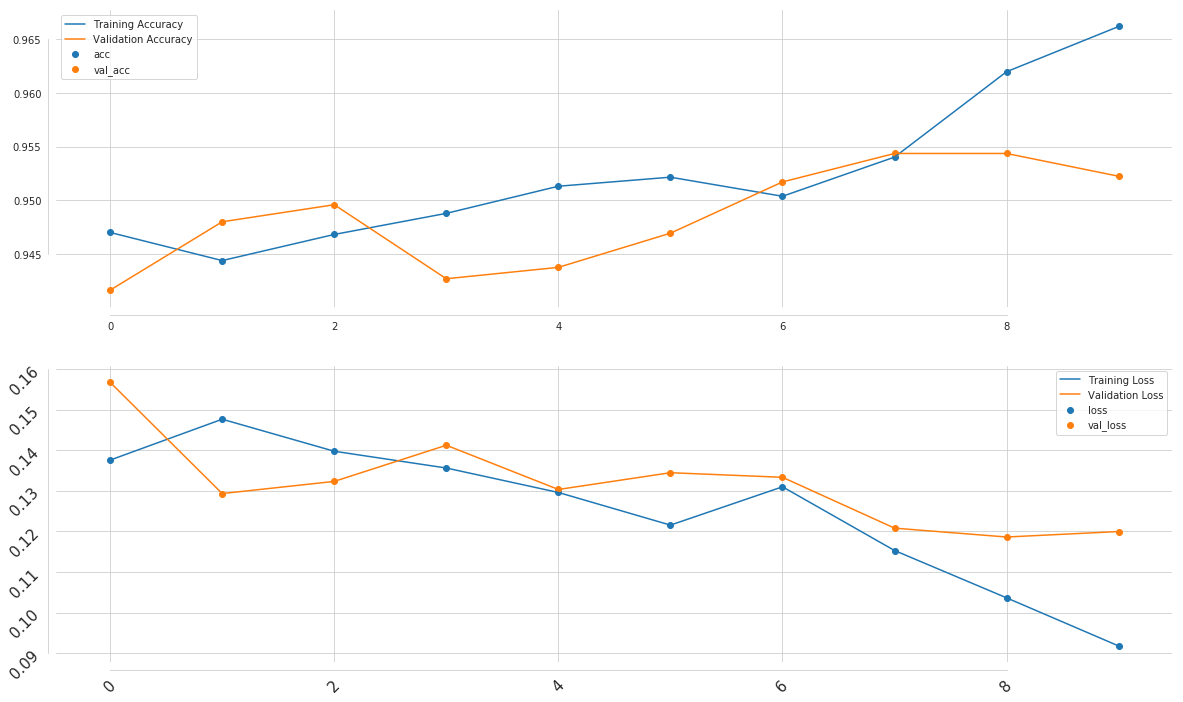

In [69]:
plot_learning(fined_history_df)

In [70]:
model.load_weights("resnet_model.h5")
y_test = model.predict_generator(
    test_gen,
    steps = len(test_gen),
    verbose = 1
)

57/57 [==============================] - 22s 393ms/step


In [0]:
test_nan_df["allMissing"] = y_test
fined_history_df.to_csv("history.csv",index=False)
train_nan_df.to_csv("train_missing_count.csv",index=False)
test_nan_df.to_csv("test_missing_count.csv",index=False)

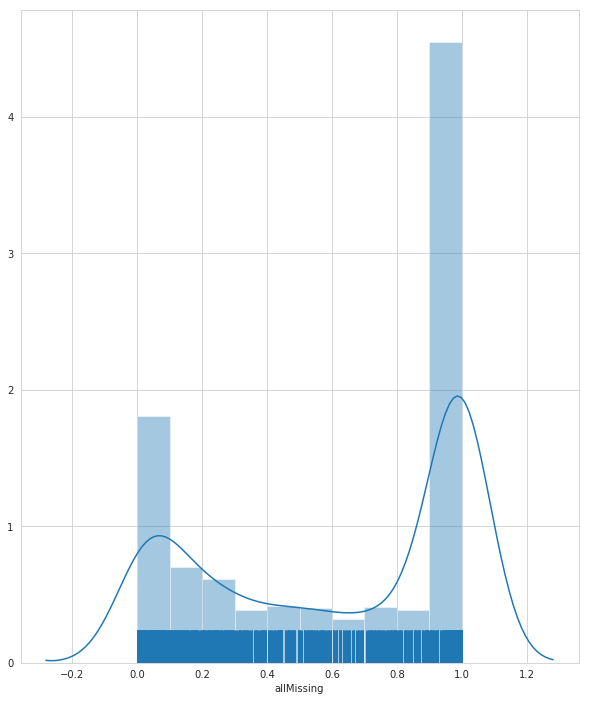

In [72]:
plt.figure(figsize=(10,12))
sns.distplot(test_nan_df["allMissing"],bins=10, rug=True, label="Distribution of Predicted labels")